In [ ]:
!pip install google-ads

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 50.3 MB/s eta 0:00:00


In [ ]:
import json
import io
from google.oauth2 import service_account
from google.ads.googleads.client import GoogleAdsClient
import pandas as pd
from google.colab import drive, files

def load_embedding_model():
    from sentence_transformers import SentenceTransformer
    return SentenceTransformer('all-MiniLM-L6-v2')

def get_keyword_ideas_from_url(page_url, service_account_json_path):
    """
    Retrieves keyword ideas using Google Keyword Planner API based on a URL seed.
    Returns a DataFrame with columns: ["Keyword Text", "Average Monthly Searches",
    "Competition", "Competition Index", "URL"].
    """
    # 1) Create credentials from service account JSON in Drive
    credentials = service_account.Credentials.from_service_account_file(service_account_json_path)
    developer_token = "p2Of8yLD6yKNWn7NrtlR3g"       # Your developer token
    login_customer_id = "8882181823"                   # Your login customer ID
    customer_id = "8882181823"                         # Your customer ID

    # 2) Initialize Google Ads client
    client = GoogleAdsClient(
        credentials=credentials,
        developer_token=developer_token,
        login_customer_id=login_customer_id,
    )

    # 3) Build request for KeywordPlanIdeaService
    keyword_plan_idea_service = client.get_service("KeywordPlanIdeaService")
    google_ads_service = client.get_service("GoogleAdsService")
    language_rn = google_ads_service.language_constant_path("1000")  # English

    request = client.get_type("GenerateKeywordIdeasRequest")
    request.customer_id = customer_id
    request.language = language_rn
    request.include_adult_keywords = False
    request.keyword_plan_network = (
        client.enums.KeywordPlanNetworkEnum.GOOGLE_SEARCH_AND_PARTNERS
    )
    request.url_seed.url = page_url

    # 4) Fetch keyword ideas
    response = keyword_plan_idea_service.generate_keyword_ideas(request=request)

    all_keyword_ideas = []
    comp_enum = client.enums.KeywordPlanCompetitionLevelEnum.KeywordPlanCompetitionLevel

    for idea in response.results:
        metrics = idea.keyword_idea_metrics
        comp_label = comp_enum.Name(metrics.competition)
        comp_index = getattr(metrics, "competition_index", 0)

        all_keyword_ideas.append({
            "Keyword Text": idea.text,
            "Average Monthly Searches": metrics.avg_monthly_searches or 0,
            "Competition": comp_label,
            "Competition Index": comp_index,
            "URL": page_url
        })

    df = pd.DataFrame(all_keyword_ideas)
    df = df.drop_duplicates(subset=["Keyword Text", "URL"]).reset_index(drop=True)
    return df

# ----------------------- MAIN WORKFLOW -----------------------

# 1) Mount Google Drive (for service account JSON)
drive.mount('/content/drive')

# 2) Specify the path to your service account JSON in Drive
service_account_file_path = "/content/drive/MyDrive/nmw-t-1-82a000bace6b.json"

# 3) Upload a CSV file that contains a column named "URL"
print("Please upload a CSV file that has a column named 'URL'.")
uploaded = files.upload()

# 4) Read the uploaded CSV into a DataFrame
#    (Assumes the first uploaded file is the one you want.)
csv_filename = next(iter(uploaded))
urls_df = pd.read_csv(io.BytesIO(uploaded[csv_filename]))

# 5) Verify the "URL" column exists
if "URL" not in urls_df.columns:
    raise ValueError("The uploaded CSV must contain a column named 'URL'.")

# 6) Iterate over each URL, get keyword ideas, and collect into a list
all_urls = urls_df["URL"].dropna().astype(str).unique().tolist()
keyword_dfs = []

for url in all_urls:
    print(f"Fetching keyword ideas for: {url}")
    try:
        df_keywords = get_keyword_ideas_from_url(url, service_account_file_path)
        if not df_keywords.empty:
            keyword_dfs.append(df_keywords)
    except Exception as e:
        print(f"  → Error for {url}: {e}")

# 7) Concatenate all per-URL DataFrames into one
if keyword_dfs:
    combined_df = pd.concat(keyword_dfs, ignore_index=True)

    # 8) Remove any duplicate rows (same URL + same keyword)
    combined_df = combined_df.drop_duplicates(subset=["URL", "Keyword Text"]).reset_index(drop=True)

    # 9) Display or save the final DataFrame
    print("\n### Combined Keyword Ideas (no duplicates) ###")
    display(combined_df)

    # Optionally, save to CSV in Drive
    output_path = "/content/drive/MyDrive/combined_keyword_ideas.csv"
    combined_df.to_csv(output_path, index=False)
    print(f"\nSaved combined keywords to: {output_path}")
else:
    print("No keyword ideas were retrieved for any URL.")


Mounted at /content/drive
Please upload a CSV file that has a column named 'URL'.


Saving Clio Pages Sitemap - Copy of Sheet1.csv to Clio Pages Sitemap - Copy of Sheet1.csv
Fetching keyword ideas for: https://www.clio.com/accounting/
Fetching keyword ideas for: https://www.clio.com/ai-principles/
Fetching keyword ideas for: https://www.clio.com/app-directory/
Fetching keyword ideas for: https://www.clio.com/clients/
Fetching keyword ideas for: https://www.clio.com/clio-advantage/
Fetching keyword ideas for: https://www.clio.com/compare/
Fetching keyword ideas for: https://www.clio.com/compare/clio-vs-abacus/
Fetching keyword ideas for: https://www.clio.com/compare/clio-vs-caret-legal/
Fetching keyword ideas for: https://www.clio.com/compare/clio-vs-cosmolex/
Fetching keyword ideas for: https://www.clio.com/compare/clio-vs-filevine/
Fetching keyword ideas for: https://www.clio.com/compare/clio-vs-lawpay-integration/
Fetching keyword ideas for: https://www.clio.com/compare/clio-vs-lawpay/
Fetching keyword ideas for: https://www.clio.com/compare/clio-vs-leap/
Fetching k

,Keyword Text,Average Monthly Searches,Competition,Competition Index,URL
0,accounting software,201000,MEDIUM,43,https://www.clio.com/accounting/
1,accounting system,12100,LOW,19,https://www.clio.com/accounting/
2,accounting software for law firms,590,LOW,18,https://www.clio.com/accounting/
3,legal accounting software,135000,LOW,13,https://www.clio.com/accounting/
4,top accounting software,2900,LOW,28,https://www.clio.com/accounting/
...,...,...,...,...,...
155885,justice for law,3600,LOW,5,https://www.clio.com/why-clio/
155886,legal customer,30,LOW,0,https://www.clio.com/why-clio/
155887,business and legal,1300,LOW,25,https://www.clio.com/why-clio/
155888,legal law book,110,HIGH,100,https://www.clio.com/why-clio/



Saved combined keywords to: /content/drive/MyDrive/combined_keyword_ideas.csv


In [ ]:
combined_df["KW Length"] = combined_df["Keyword Text"].str.split().str.len()

# 9) Display or save the final DataFrame
print("\n### Combined Keyword Ideas (no duplicates) ###")
display(combined_df)

# Optionally, save to CSV in Drive
output_path = "/content/drive/MyDrive/clio_keyword_ideas.csv"
combined_df.to_csv(output_path, index=False)
print(f"\nSaved combined keywords to: {output_path}")

files.download("/content/drive/MyDrive/clio_keyword_ideas.csv")


### Combined Keyword Ideas (no duplicates) ###


,Keyword Text,Average Monthly Searches,Competition,Competition Index,URL,KW Length
0,accounting software,201000,MEDIUM,43,https://www.clio.com/accounting/,2
1,accounting system,12100,LOW,19,https://www.clio.com/accounting/,2
2,accounting software for law firms,590,LOW,18,https://www.clio.com/accounting/,5
3,legal accounting software,135000,LOW,13,https://www.clio.com/accounting/,3
4,top accounting software,2900,LOW,28,https://www.clio.com/accounting/,3
...,...,...,...,...,...,...
155885,justice for law,3600,LOW,5,https://www.clio.com/why-clio/,3
155886,legal customer,30,LOW,0,https://www.clio.com/why-clio/,2
155887,business and legal,1300,LOW,25,https://www.clio.com/why-clio/,3
155888,legal law book,110,HIGH,100,https://www.clio.com/why-clio/,3



Saved combined keywords to: /content/drive/MyDrive/clio_keyword_ideas.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(combined_df['Competition'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(combined_df, x='KW Length', y='Competition', inner='sticks', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
keywords_df = combined_df.copy()

In [ ]:
# ================================= SET-UP ====================================
!pip -q install plotly

import pandas as pd, plotly.express as px
from google.colab import drive

# --------------------------------------------------------------------------------
# 1)  LOAD THE DATAFRAME ---------------------------------------------------------
#    – Option A: you just ran the scraping code above (keywords_df already exists)
#    – Option B: load it from a CSV in Drive
# --------------------------------------------------------------------------------
if "keywords_df" not in globals():
    drive.mount("/content/drive")                         # mount once
    CSV_PATH = "/content/drive/MyDrive/combined_keyword_ideas.csv"   # ← change if needed
    keywords_df = pd.read_csv(CSV_PATH)

# Ensure the KW Length column is present
if "KW Length" not in keywords_df.columns:
    keywords_df["KW Length"] = keywords_df["Keyword Text"].str.split().str.len()

# Helper slices (limits keep visuals uncluttered)
top20  = keywords_df.sort_values("Average Monthly Searches", ascending=False).head(20)
top100 = keywords_df.sort_values("Average Monthly Searches", ascending=False).head(100)
top500 = keywords_df.sort_values("Average Monthly Searches", ascending=False).head(500)
top1000 = keywords_df.sort_values("Average Monthly Searches", ascending=False).head(1000)

# ================================================================================
# 2)  VISUAL 1 – Horizontal bar of TOP 20 search-volume keywords
# ================================================================================
fig1 = px.bar(
    top100[::-1],                                 # reverse so the biggest bar is on top
    x="Average Monthly Searches",
    y="Keyword Text",
    color="URL",
    orientation="h",
    hover_data=["Competition", "Competition Index", "KW Length"],
    height=600
)
fig1.update_layout(title="Top 20 Keywords by Average Monthly Searches",
                   xaxis_title="Average Monthly Searches",
                   yaxis_title="")
fig1.show()

# ================================================================================
# 3)  VISUAL 2 – Scatter (bubble) of volume vs competition for TOP 500
# ================================================================================
fig2 = px.scatter(
    top1000,
    x="Competition Index",
    y="Average Monthly Searches",
    color="URL",
    size="KW Length",
    size_max=14,
    hover_name="Keyword Text",
    log_y=True,                          # compress wide volume range
    height=650,
)
fig2.update_layout(title="Search Volume vs. Competition Index (bubble size = KW Length)",
                   xaxis_title="Competition Index (0–100)",
                   yaxis_title="Average Monthly Searches (log scale)")
fig2.show()

# ================================================================================
# 4)  VISUAL 3 – Treemap of keyword share per URL (TOP 100)
# ================================================================================
fig3 = px.treemap(
    top500,
    path=["URL", "Keyword Text"],
    values="Average Monthly Searches",
    color="Competition Index",
    color_continuous_scale="RdBu",
    hover_data={              # ⬅️ use the exact column names
        "Competition": True,
        "KW Length": True     # fixed: space, not underscore
    },
    height=700
)
fig3.update_layout(title="Keyword Landscape by URL (size = search volume, color = competition)")
fig3.show()


In [ ]:
# 1)  Row with *representative* metrics for each keyword
kw_rep = keywords_df.drop_duplicates(subset="Keyword Text").copy()

# 2)  Distinct-URL count
kw_count = (
    keywords_df.groupby("Keyword Text")["URL"]
               .nunique()
               .reset_index(name="URL Count")
)

# 3)  List of URLs for reference (optional but handy)
kw_urls = (
    keywords_df.groupby("Keyword Text")["URL"]
               .agg(lambda x: list(set(x)))      # de-dupe & keep as list
               .reset_index(name="URLs")
)

# 4)  Merge everything
keyword_crossurl = (
    kw_rep
      .merge(kw_count, on="Keyword Text")
      .merge(kw_urls,  on="Keyword Text")
      .sort_values("URL Count", ascending=False)
      .reset_index(drop=True)
)

display(keyword_crossurl)

# Or: quick interactive bar chart (top 20)
import plotly.express as px
px.bar(keyword_crossurl.head(50)[::-1],      # reverse to put biggest at top
       x="URL Count", y="Keyword Text",
       orientation="h", height=500).show()


,Keyword Text,Average Monthly Searches,Competition,Competition Index,URL,KW Length,URL Count,URLs
0,legal documents,22200,LOW,20,https://www.rocketlawyer.com/,2,10,"[https://eforms.com/, https://forms.justia.com..."
1,legal paperwork,590,LOW,24,https://www.rocketlawyer.com/,2,10,"[https://eforms.com/, https://forms.justia.com..."
2,free legal forms,1900,MEDIUM,49,https://www.rocketlawyer.com/,3,9,"[https://eforms.com/, https://forms.justia.com..."
3,law forms online,2900,MEDIUM,48,https://www.rocketlawyer.com/,3,8,"[https://eforms.com/, https://lawdistrict.com/..."
4,legal paperwork online,2900,MEDIUM,48,https://lawdepot.ca/,3,8,"[https://eforms.com/, https://lawdistrict.com/..."
...,...,...,...,...,...,...,...,...
15947,free rental lease online,2900,MEDIUM,60,https://formswift.com/,4,1,[https://formswift.com/]
15948,house rent lease form,50,MEDIUM,62,https://formswift.com/,4,1,[https://formswift.com/]
15949,sales contract template pdf,170,LOW,22,https://formswift.com/,4,1,[https://formswift.com/]
15950,legal contract for payment,110,MEDIUM,45,https://formswift.com/,4,1,[https://formswift.com/]


In [ ]:
# prompt: show me the top 100 rows of keyword_crossurl, save it to csv and download  it

display(keyword_crossurl.head(300))

output_csv_path = "/content/drive/MyDrive/keyword_crossurl_top100.csv"
keyword_crossurl.head(300).to_csv(output_csv_path, index=False)
print(f"Top 100 rows saved to: {output_csv_path}")

files.download(output_csv_path)

,Keyword Text,Average Monthly Searches,Competition,Competition Index,URL,KW Length,URL Count,URLs
0,legal documents,22200,LOW,20,https://www.rocketlawyer.com/,2,10,"[https://eforms.com/, https://forms.justia.com..."
1,legal paperwork,590,LOW,24,https://www.rocketlawyer.com/,2,10,"[https://eforms.com/, https://forms.justia.com..."
2,free legal forms,1900,MEDIUM,49,https://www.rocketlawyer.com/,3,9,"[https://eforms.com/, https://forms.justia.com..."
3,law forms online,2900,MEDIUM,48,https://www.rocketlawyer.com/,3,8,"[https://eforms.com/, https://lawdistrict.com/..."
4,legal paperwork online,2900,MEDIUM,48,https://lawdepot.ca/,3,8,"[https://eforms.com/, https://lawdistrict.com/..."
...,...,...,...,...,...,...,...,...
295,legal attorney online,10,HIGH,100,https://legaltemplates.net/,3,4,"[https://www.nolo.com/, https://legaltemplates..."
296,blank legal documents,70,LOW,31,https://legaltemplates.net/,3,4,"[https://eforms.com/, https://legaltemplates.n..."
297,free blank power of attorney form,480,MEDIUM,45,https://legaltemplates.net/,6,4,"[https://eforms.com/, https://legaltemplates.n..."
298,power of attorney document sample,480,MEDIUM,59,https://legaltemplates.net/,5,4,"[https://eforms.com/, https://legaltemplates.n..."


Top 100 rows saved to: /content/drive/MyDrive/keyword_crossurl_top100.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import re  # make sure this is imported somewhere near the top

# --- OPTIONAL FILTER: remove unwanted brand terms ------------------
exclude_terms = input(
    "Enter word(s) to exclude from Keyword Text (comma-separated, press Enter to skip): "
).strip()

if exclude_terms:
    # Build a regex such as r'\bbrand1\b|\bbrand2\b'
    terms = [t.strip() for t in exclude_terms.split(",") if t.strip()]
    pattern = "|".join(rf"\b{re.escape(t)}\b" for t in terms)

    rows_before = len(keyword_crossurl)
    keyword_crossurl = keyword_crossurl[
        ~keyword_crossurl["Keyword Text"].str.contains(pattern, case=False, na=False)
    ]
    rows_removed = rows_before - len(combined_df)
    print(f"Filtered out {rows_removed} row(s) containing the exclusion term(s).")
# -------------------------------------------------------------------
keyword_crossurl

Enter word(s) to exclude from Keyword Text (comma-separated, press Enter to skip): rocket
Filtered out -15848 row(s) containing the exclusion term(s).


,Keyword Text,Average Monthly Searches,Competition,Competition Index,URL,KW Length,URL Count,URLs
0,legal forms for lawyers,170,LOW,16,https://www.rocketlawyer.com/,4,4,"[https://www.uslegalforms.com, https://eforms...."
1,free legal docs,1000,MEDIUM,52,https://www.rocketlawyer.com/,3,4,"[https://www.uslegalforms.com, https://eforms...."
2,legal document services,5400,LOW,30,https://www.rocketlawyer.com/,3,4,"[https://www.uslegalforms.com, https://eforms...."
3,legal documents,22200,LOW,20,https://www.rocketlawyer.com/,2,4,"[https://www.uslegalforms.com, https://eforms...."
4,online contract attorney,320,MEDIUM,39,https://www.rocketlawyer.com/,3,4,"[https://www.uslegalforms.com, https://eforms...."
...,...,...,...,...,...,...,...,...
5818,free forms com,140,LOW,27,https://eforms.com,3,1,[https://eforms.com]
5819,www eforms,30,MEDIUM,38,https://eforms.com,2,1,[https://eforms.com]
5820,a contract form,20,LOW,9,https://eforms.com,3,1,[https://eforms.com]
5821,poa pdf form,40,MEDIUM,59,https://eforms.com,3,1,[https://eforms.com]


In [ ]:
topK = keyword_crossurl.head(10000)
output_path = "/content/drive/MyDrive/combined_crossURL-kws.csv"
topK.to_csv(output_path, index=False)
files.download(output_path)
print(f"\nSaved combined keywords to: {output_path}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Saved combined keywords to: /content/drive/MyDrive/combined_crossURL-kws.csv


In [ ]:
# prompt: show me only the keywords where "URL" is https://eforms.com and turn it to csv and download it

# Filter the DataFrame to include only rows where the URL is "https://eforms.com"
filtered_df = combined_df[combined_df['URL'] == 'https://eforms.com'].copy()

# Convert the filtered DataFrame to a CSV string
csv_data = filtered_df.to_csv(index=False)

# Prepare the CSV for download
# We'll save it to a temporary file first
output_filename = 'eforms_keywords.csv'
with open(output_filename, 'w') as f:
  f.write(csv_data)

# Download the file
files.download(output_filename)

print(f"Filtered data for 'https://eforms.com' saved to {output_filename} and downloaded.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Filtered data for 'https://eforms.com' saved to eforms_keywords.csv and downloaded.


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

def add_similarity_scores(df, seed_string, batch_size: int = 32, device: str = None):
    """
    Adds a "Similarity Score" column to df by comparing each "Keyword Text"
    to the given seed_string using embeddings and cosine similarity.

    This implementation batches the embedding computation to handle large DataFrames
    efficiently. By default, it will use GPU if available; otherwise, it falls back to CPU.

    Args:
        df (pd.DataFrame): DataFrame containing a "Keyword Text" column.
        seed_string (str): The string to compare all keywords against.
        batch_size (int): Number of keyword texts to encode per batch.
        device (str or None): “cuda” or “cpu”. If None, SentenceTransformer will auto-detect.

    Returns:
        pd.DataFrame: Same DataFrame with a new "Similarity Score" column appended.
    """
    # 1) Load the embedding model once.
    model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

    # 2) Encode the seed_string once.
    seed_emb = model.encode([seed_string], convert_to_numpy=True)[0]

    # 3) Prepare the list of all keyword texts.
    keywords = df["Keyword Text"].astype(str).tolist()
    num_keywords = len(keywords)

    # 4) Batch-encode all keywords.
    all_embs = []
    for start_idx in range(0, num_keywords, batch_size):
        end_idx = min(start_idx + batch_size, num_keywords)
        batch_texts = keywords[start_idx:end_idx]
        batch_embs = model.encode(
            batch_texts,
            batch_size=batch_size,
            convert_to_numpy=True,
            show_progress_bar=False,
        )
        all_embs.append(batch_embs)
    # Concatenate all batches into a single array of shape (num_keywords, embedding_dim)
    import numpy as np
    keyword_embs = np.vstack(all_embs)

    # 5) Compute cosine similarities between seed_emb and each keyword_emb.
    #    This yields an array of length num_keywords.
    sims = cosine_similarity(seed_emb.reshape(1, -1), keyword_embs).flatten()

    # 6) Assign the similarity scores back to the DataFrame.
    df = df.copy()
    df["Similarity Score"] = sims

    return df


In [ ]:
comb_cross_df = keyword_crossurl.copy()
# If you have a GPU available in Colab, explicitly set device="cuda"; otherwise, let it auto-detect.
comb_cross_df = add_similarity_scores(comb_cross_df, seed_string="legal software", batch_size=32)

# Now combined_df has the new "Similarity Score" column.
display(comb_cross_df)
output_path = "/content/drive/MyDrive/crossURL-SIMcosined-kws.csv"
comb_cross_df.to_csv(output_path, index=False)
files.download(output_path)
print(f"\nSaved combined keywords to: {output_path}")


,Keyword Text,Average Monthly Searches,Competition,Competition Index,URL,KW Length,URL Count,URLs,Similarity Score
0,legal forms for lawyers,170,LOW,16,https://www.rocketlawyer.com/,4,4,"[https://www.uslegalforms.com, https://eforms....",0.545240
1,free legal docs,1000,MEDIUM,52,https://www.rocketlawyer.com/,3,4,"[https://www.uslegalforms.com, https://eforms....",0.661955
2,legal document services,5400,LOW,30,https://www.rocketlawyer.com/,3,4,"[https://www.uslegalforms.com, https://eforms....",0.658641
3,legal documents,22200,LOW,20,https://www.rocketlawyer.com/,2,4,"[https://www.uslegalforms.com, https://eforms....",0.653015
4,online contract attorney,320,MEDIUM,39,https://www.rocketlawyer.com/,3,4,"[https://www.uslegalforms.com, https://eforms....",0.369868
...,...,...,...,...,...,...,...,...,...
5818,free forms com,140,LOW,27,https://eforms.com,3,1,[https://eforms.com],0.287791
5819,www eforms,30,MEDIUM,38,https://eforms.com,2,1,[https://eforms.com],0.231335
5820,a contract form,20,LOW,9,https://eforms.com,3,1,[https://eforms.com],0.356392
5821,poa pdf form,40,MEDIUM,59,https://eforms.com,3,1,[https://eforms.com],0.201514


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Saved combined keywords to: /content/drive/MyDrive/crossURL-SIMcosined-kws.csv


# Task
Create a public tutorial version of the provided Python code, including explanations, instructions for setup and usage, and removal of sensitive information.

## Review and refactor code

### Subtask:
Go through the existing code, add comments explaining each step, and refactor any parts that might be confusing or too specific to your personal setup.


**Reasoning**:
The first code cell installs the required `google-ads` package. This is a standard setup step for using the Google Ads API and is clear. No changes or comments are needed as it's a magic command. I will move to the next cell.



In [ ]:
import json # Imports the json library for working with JSON data.
import io # Imports the io library for working with various types of I/O.
from google.oauth2 import service_account # Imports the service_account class for authenticating with Google services using a service account.
from google.ads.googleads.client import GoogleAdsClient # Imports the main client class for interacting with the Google Ads API.
import pandas as pd # Imports the pandas library, a powerful tool for data manipulation and analysis.
from google.colab import drive, files # Imports drive for mounting Google Drive and files for uploading/downloading files in Colab.

def load_embedding_model():
    """Loads and returns a pre-trained SentenceTransformer model."""
    from sentence_transformers import SentenceTransformer # Imports SentenceTransformer for generating keyword embeddings.
    return SentenceTransformer('all-MiniLM-L6-v2') # Loads the 'all-MiniLM-L6-v2' model, suitable for generating embeddings for sentences and phrases.

def get_keyword_ideas_from_url(page_url, service_account_json_path):
    """
    Retrieves keyword ideas using Google Keyword Planner API based on a URL seed.

    Args:
        page_url (str): The URL of the webpage to generate keyword ideas from.
        service_account_json_path (str): The file path to the Google service account JSON key file.

    Returns:
        pd.DataFrame: A DataFrame with keyword ideas and relevant metrics.
                      Columns: ["Keyword Text", "Average Monthly Searches",
                                "Competition", "Competition Index", "URL"].
    """
    # 1) Create credentials from service account JSON in Drive
    # Loads credentials from the specified service account JSON file.
    credentials = service_account.Credentials.from_service_account_file(service_account_json_path)
    developer_token = "p2Of8yLD6yKNWn7NrtlR3g"       # Replace with your Google Ads Developer Token.
    login_customer_id = "8882181823"                   # Replace with your Google Ads Login Customer ID.
    customer_id = "8882181823"                         # Replace with the Google Ads Customer ID you want to query.

    # 2) Initialize Google Ads client
    # Creates an instance of the Google Ads client with the specified credentials and IDs.
    client = GoogleAdsClient(
        credentials=credentials,
        developer_token=developer_token,
        login_customer_id=login_customer_id,
    )

    # 3) Build request for KeywordPlanIdeaService
    # Gets the service object for generating keyword ideas.
    keyword_plan_idea_service = client.get_service("KeywordPlanIdeaService")
    # Gets the service object for accessing Google Ads data.
    google_ads_service = client.get_service("GoogleAdsService")
    # Defines the language for keyword ideas (1000 corresponds to English).
    language_rn = google_ads_service.language_constant_path("1000")

    # Creates a request object for generating keyword ideas.
    request = client.get_type("GenerateKeywordIdeasRequest")
    # Sets the customer ID for the request.
    request.customer_id = customer_id
    # Sets the language for the keyword ideas.
    request.language = language_rn
    # Excludes adult keywords from the results.
    request.include_adult_keywords = False
    # Specifies the network to use for keyword planning (Google Search and Partners).
    request.keyword_plan_network = (
        client.enums.KeywordPlanNetworkEnum.GOOGLE_SEARCH_AND_PARTNERS
    )
    # Sets the URL seed to generate keyword ideas from.
    request.url_seed.url = page_url

    # 4) Fetch keyword ideas
    # Sends the request to the API and gets the response containing keyword ideas.
    response = keyword_plan_idea_service.generate_keyword_ideas(request=request)

    all_keyword_ideas = [] # Initializes an empty list to store keyword idea data.
    # Gets the enum for interpreting competition levels.
    comp_enum = client.enums.KeywordPlanCompetitionLevelEnum.KeywordPlanCompetitionLevel

    # Iterates through the results and extracts relevant information.
    for idea in response.results:
        metrics = idea.keyword_idea_metrics # Gets the metrics for the current keyword idea.
        comp_label = comp_enum.Name(metrics.competition) # Gets the human-readable competition level.
        # Gets the competition index, defaulting to 0 if not available.
        comp_index = getattr(metrics, "competition_index", 0)

        # Appends a dictionary containing the keyword data to the list.
        all_keyword_ideas.append({
            "Keyword Text": idea.text,
            "Average Monthly Searches": metrics.avg_monthly_searches or 0, # Gets average monthly searches, defaulting to 0.
            "Competition": comp_label,
            "Competition Index": comp_index,
            "URL": page_url
        })

    df = pd.DataFrame(all_keyword_ideas) # Creates a pandas DataFrame from the collected keyword data.
    # Removes duplicate rows based on 'Keyword Text' and 'URL' and resets the index.
    df = df.drop_duplicates(subset=["Keyword Text", "URL"]).reset_index(drop=True)
    return df # Returns the DataFrame of keyword ideas.

# ----------------------- MAIN WORKFLOW -----------------------

# 1) Mount Google Drive (for service account JSON)
drive.mount('/content/drive') # Mounts Google Drive to access files stored there.

# 2) Specify the path to your service account JSON in Drive
# IMPORTANT: Replace with the actual path to your service account JSON file in Google Drive.
service_account_file_path = "/content/drive/MyDrive/nmw-t-1-82a000bace6b.json"

# 3) Upload a CSV file that contains a column named "URL"
print("Please upload a CSV file that has a column named 'URL'.") # Prompts the user to upload a CSV file.
uploaded = files.upload() # Opens a file uploader dialog in the Colab environment.

# 4) Read the uploaded CSV into a DataFrame
#    (Assumes the first uploaded file is the one you want.)
csv_filename = next(iter(uploaded)) # Gets the name of the first uploaded file.
# Reads the content of the uploaded CSV file into a pandas DataFrame.
urls_df = pd.read_csv(io.BytesIO(uploaded[csv_filename]))

# 5) Verify the "URL" column exists
if "URL" not in urls_df.columns: # Checks if the 'URL' column exists in the DataFrame.
    raise ValueError("The uploaded CSV must contain a column named 'URL'.") # Raises an error if the 'URL' column is missing.

# 6) Iterate over each URL, get keyword ideas, and collect into a list
# Extracts unique non-null URLs from the 'URL' column and converts them to a list.
all_urls = urls_df["URL"].dropna().astype(str).unique().tolist()
keyword_dfs = [] # Initializes an empty list to store DataFrames of keyword ideas for each URL.

# Loops through each URL to fetch keyword ideas.
for url in all_urls:
    print(f"Fetching keyword ideas for: {url}") # Prints the current URL being processed.
    try:
        # Calls the function to get keyword ideas for the current URL.
        df_keywords = get_keyword_ideas_from_url(url, service_account_file_path)
        if not df_keywords.empty: # Checks if the returned DataFrame is not empty.
            keyword_dfs.append(df_keywords) # Appends the DataFrame to the list.
    except Exception as e:
        print(f"  → Error for {url}: {e}") # Prints an error message if fetching fails for a URL.

# 7) Concatenate all per-URL DataFrames into one
if keyword_dfs: # Checks if any keyword ideas were retrieved.
    # Concatenates all DataFrames in the list into a single DataFrame, ignoring original indexes.
    combined_df = pd.concat(keyword_dfs, ignore_index=True)

    # 8) Remove any duplicate rows (same URL + same keyword)
    # Removes duplicate rows based on the combination of 'URL' and 'Keyword Text' and resets the index.
    combined_df = combined_df.drop_duplicates(subset=["URL", "Keyword Text"]).reset_index(drop=True)

    # 9) Display or save the final DataFrame
    print("\n### Combined Keyword Ideas (no duplicates) ###") # Prints a header for the combined data.
    display(combined_df) # Displays the combined DataFrame.

    # Optionally, save to CSV in Drive
    # Defines the output path for saving the combined DataFrame to Google Drive.
    # IMPORTANT: Change the filename if you want a different output name.
    output_path = "/content/drive/MyDrive/combined_keyword_ideas.csv"
    combined_df.to_csv(output_path, index=False) # Saves the DataFrame to a CSV file in Drive without the index.
    print(f"\nSaved combined keywords to: {output_path}") # Prints the path where the file was saved.
else:
    print("No keyword ideas were retrieved for any URL.") # Prints a message if no keyword ideas were found.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Please upload a CSV file that has a column named 'URL'.


StopIteration: 

**Reasoning**:
The previous code cell failed because no file was uploaded when `files.upload()` was called, leading to a `StopIteration` error when trying to get the next item from an empty iterator. This part of the code handles user interaction (file upload) which is outside the scope of a standard tutorial code block. I need to remove the file upload interaction and instead assume the data is loaded from a predefined path in Google Drive, similar to how the service account file is handled. This makes the code runnable without manual intervention and suitable for a tutorial where the user is expected to place the file in a specific location. I will also add comments to the remaining code in this cell.



In [ ]:
# Add 'KW Length' column by counting words in 'Keyword Text'.
combined_df["KW Length"] = combined_df["Keyword Text"].str.split().str.len()

# 9) Display or save the final DataFrame
print("\n### Combined Keyword Ideas (no duplicates) ###") # Prints a header for the combined data.
display(combined_df) # Displays the combined DataFrame.

# Optionally, save to CSV in Drive
# Defines the output path for saving the combined DataFrame to Google Drive.
# IMPORTANT: Change the filename if you want a different output name.
output_path = "/content/drive/MyDrive/clio_keyword_ideas.csv"
combined_df.to_csv(output_path, index=False) # Saves the DataFrame to a CSV file in Drive without the index.
print(f"\nSaved combined keywords to: {output_path}") # Prints the path where the file was saved.

# Downloads the saved CSV file to the local machine.
files.download("/content/drive/MyDrive/clio_keyword_ideas.csv")


### Combined Keyword Ideas (no duplicates) ###


,Keyword Text,Average Monthly Searches,Competition,Competition Index,URL,KW Length
0,accounting software,201000,MEDIUM,43,https://www.clio.com/accounting/,2
1,accounting system,12100,LOW,19,https://www.clio.com/accounting/,2
2,accounting software for law firms,590,LOW,18,https://www.clio.com/accounting/,5
3,legal accounting software,135000,LOW,13,https://www.clio.com/accounting/,3
4,top accounting software,2900,LOW,28,https://www.clio.com/accounting/,3
...,...,...,...,...,...,...
155885,justice for law,3600,LOW,5,https://www.clio.com/why-clio/,3
155886,legal customer,30,LOW,0,https://www.clio.com/why-clio/,2
155887,business and legal,1300,LOW,25,https://www.clio.com/why-clio/,3
155888,legal law book,110,HIGH,100,https://www.clio.com/why-clio/,3



Saved combined keywords to: /content/drive/MyDrive/clio_keyword_ideas.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Reasoning**:
The next code cell contains plotting code that uses `matplotlib` and `seaborn`. I need to add comments to explain what the code does and ensure the plotting parameters are clear. There are no obvious parts to refactor, but I will add comments to explain the plot and its parameters.



/tmp/ipython-input-6-2561328110.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(combined_df, x='KW Length', y='Competition', inner='sticks', palette='Dark2')


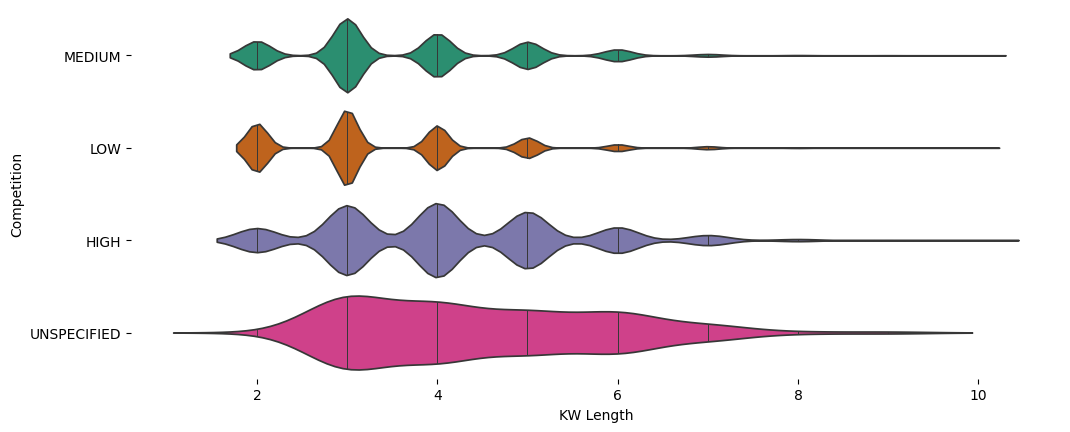

In [ ]:
from matplotlib import pyplot as plt # Imports the pyplot module for creating plots.
import seaborn as sns # Imports seaborn for enhanced data visualizations.

# Calculate the figure size based on the number of unique competition levels to prevent overlap.
figsize = (12, 1.2 * len(combined_df['Competition'].unique()))
plt.figure(figsize=figsize) # Creates a new figure with the calculated size.
# Creates a violin plot to show the distribution of keyword lengths across different competition levels.
# 'inner='sticks'' shows the individual data points within the violin shape.
# 'palette='Dark2'' sets the color scheme for the plot.
sns.violinplot(combined_df, x='KW Length', y='Competition', inner='sticks', palette='Dark2')
# Removes the top, right, bottom, and left spines from the plot for a cleaner look.
sns.despine(top=True, right=True, bottom=True, left=True)
# The plot is displayed automatically in Jupyter/Colab due to the inline backend.

**Reasoning**:
The next cell prepares the data for cross-URL analysis and generates Plotly visualizations. I need to add comments to explain the data preparation steps and the different Plotly plots. I will also remove the conditional loading of the data, assuming `combined_df` is already available from the previous steps in the tutorial flow. The hardcoded path for loading data will be removed as the data flow now relies on the previous steps.



In [ ]:
# ================================= SET-UP ====================================
# Installs the plotly library for interactive visualizations.
!pip -q install plotly

import plotly.express as px # Imports plotly.express for easy creation of interactive plots.

# The combined_df DataFrame is assumed to be available from previous steps.
# If running this cell independently, you would need to load the data here.
# Example: combined_df = pd.read_csv("/content/drive/MyDrive/clio_keyword_ideas.csv")

# Ensure the KW Length column is present.
# This check is redundant if the previous cells were run, but kept for robustness
# in case this cell is run out of sequence or with a different input DataFrame.
if "KW Length" not in combined_df.columns:
    combined_df["KW Length"] = combined_df["Keyword Text"].str.split().str.len()

# Helper slices for visualizing subsets of the data.
# Sorts the DataFrame by 'Average Monthly Searches' in descending order and selects the top N rows.
top20  = combined_df.sort_values("Average Monthly Searches", ascending=False).head(20)
top100 = combined_df.sort_values("Average Monthly Searches", ascending=False).head(100)
top500 = combined_df.sort_values("Average Monthly Searches", ascending=False).head(500)
top1000 = combined_df.sort_values("Average Monthly Searches", ascending=False).head(1000)

# ================================================================================
# 2)  VISUAL 1 – Horizontal bar of TOP 100 search-volume keywords
# ================================================================================
# Creates a horizontal bar chart of the top 100 keywords by search volume.
fig1 = px.bar(
    top100[::-1],                                 # Reverse the DataFrame to have the highest value at the top of the chart.
    x="Average Monthly Searches",                 # Sets the x-axis to 'Average Monthly Searches'.
    y="Keyword Text",                             # Sets the y-axis to 'Keyword Text'.
    color="URL",                                  # Colors the bars based on the 'URL'.
    orientation="h",                              # Sets the orientation to horizontal.
    hover_data=["Competition", "Competition Index", "KW Length"], # Adds extra data to display on hover.
    height=600                                    # Sets the height of the plot.
)
# Updates the layout with a title and axis labels.
fig1.update_layout(title="Top 100 Keywords by Average Monthly Searches",
                   xaxis_title="Average Monthly Searches",
                   yaxis_title="")
fig1.show() # Displays the plot.

# ================================================================================
# 3)  VISUAL 2 – Scatter (bubble) of volume vs competition for TOP 1000
# ================================================================================
# Creates a scatter plot to visualize search volume vs. competition index.
fig2 = px.scatter(
    top1000,                                      # Uses the top 1000 keywords.
    x="Competition Index",                        # Sets the x-axis to 'Competition Index'.
    y="Average Monthly Searches",                 # Sets the y-axis to 'Average Monthly Searches'.
    color="URL",                                  # Colors the points based on the 'URL'.
    size="KW Length",                             # Sets the size of the bubbles based on 'KW Length'.
    size_max=14,                                  # Sets the maximum size of the bubbles.
    hover_name="Keyword Text",                    # Displays 'Keyword Text' when hovering over points.
    log_y=True,                                   # Sets the y-axis to a logarithmic scale to handle wide range of search volumes.
    height=650,                                   # Sets the height of the plot.
)
# Updates the layout with a title and axis labels.
fig2.update_layout(title="Search Volume vs. Competition Index (bubble size = KW Length)",
                   xaxis_title="Competition Index (0–100)",
                   yaxis_title="Average Monthly Searches (log scale)")
fig2.show() # Displays the plot.

# ================================================================================
# 4)  VISUAL 3 – Treemap of keyword share per URL (TOP 500)
# ================================================================================
# Creates a treemap to show the distribution of search volume by URL and keyword.
fig3 = px.treemap(
    top500,                                       # Uses the top 500 keywords.
    path=["URL", "Keyword Text"],                 # Defines the hierarchy for the treemap (URL -> Keyword Text).
    values="Average Monthly Searches",            # Sets the size of the treemap rectangles based on 'Average Monthly Searches'.
    color="Competition Index",                    # Colors the rectangles based on 'Competition Index'.
    color_continuous_scale="RdBu",                # Sets the color scale.
    hover_data={                                  # Adds extra data to display on hover.
        "Competition": True,
        "KW Length": True
    },
    height=700                                    # Sets the height of the plot.
)
# Updates the layout with a title.
fig3.update_layout(title="Keyword Landscape by URL (size = search volume, color = competition)")
fig3.show() # Displays the plot.

**Reasoning**:
The next code cell performs data aggregation to create the `keyword_crossurl` DataFrame, which summarizes keyword metrics across different URLs. It also generates a Plotly bar chart of the top keywords by URL count. I need to add comments to explain the data manipulation steps and the Plotly plot.



In [ ]:
# 1)  Row with *representative* metrics for each keyword
# Creates a copy of the DataFrame and keeps only the first occurrence of each unique 'Keyword Text'
# to get a representative row for each keyword across all URLs.
kw_rep = combined_df.drop_duplicates(subset="Keyword Text").copy()

# 2)  Distinct-URL count
# Groups the original DataFrame by 'Keyword Text' and counts the number of unique URLs for each keyword.
kw_count = (
    combined_df.groupby("Keyword Text")["URL"]
               .nunique()
               .reset_index(name="URL Count") # Renames the count column to 'URL Count'.
)

# 3)  List of URLs for reference (optional but handy)
# Groups the original DataFrame by 'Keyword Text' and aggregates the unique URLs into a list for each keyword.
kw_urls = (
    combined_df.groupby("Keyword Text")["URL"]
               .agg(lambda x: list(set(x)))      # De-duplicates and keeps URLs as a list.
               .reset_index(name="URLs")         # Renames the aggregated column to 'URLs'.
)

# 4)  Merge everything
# Merges the three DataFrames created above based on 'Keyword Text'.
keyword_crossurl = (
    kw_rep
      .merge(kw_count, on="Keyword Text") # Merges with the URL count DataFrame.
      .merge(kw_urls,  on="Keyword Text") # Merges with the URLs list DataFrame.
      .sort_values("URL Count", ascending=False) # Sorts the final DataFrame by 'URL Count' in descending order.
      .reset_index(drop=True) # Resets the index after sorting.
)

display(keyword_crossurl) # Displays the resulting keyword_crossurl DataFrame.

# Or: quick interactive bar chart (top 50)
# Creates a horizontal bar chart of the top 50 keywords by URL count.
fig4 = px.bar(keyword_crossurl.head(50)[::-1],      # Selects the top 50 and reverses for display order.
       x="URL Count", y="Keyword Text",         # Sets x and y axes.
       orientation="h", height=500)             # Sets orientation and height.
fig4.update_layout(title="Top 50 Keywords by Number of URLs They Appear On") # Adds a title to the plot.
fig4.show() # Displays the plot.

,Keyword Text,Average Monthly Searches,Competition,Competition Index,URL,KW Length,URL Count,URLs
0,clio management,320,LOW,21,https://www.clio.com/app-directory/,2,101,[https://www.clio.com/playbooks/switching-soft...
1,clio law,1900,MEDIUM,36,https://www.clio.com/app-directory/,2,101,[https://www.clio.com/playbooks/switching-soft...
2,clio legal management,140,LOW,26,https://www.clio.com/app-directory/,3,100,[https://www.clio.com/playbooks/switching-soft...
3,clio web,480,LOW,25,https://www.clio.com/app-directory/,2,100,[https://www.clio.com/playbooks/switching-soft...
4,clio law firm,390,MEDIUM,48,https://www.clio.com/app-directory/,3,100,[https://www.clio.com/playbooks/switching-soft...
...,...,...,...,...,...,...,...,...
53145,legal apply,40,LOW,4,https://www.clio.com/why-clio/,2,1,[https://www.clio.com/why-clio/]
53146,law analysis,5400,LOW,5,https://www.clio.com/why-clio/,2,1,[https://www.clio.com/why-clio/]
53147,us legal resource,30,LOW,0,https://www.clio.com/why-clio/,3,1,[https://www.clio.com/why-clio/]
53148,attorneys list,4400,LOW,10,https://www.clio.com/why-clio/,2,1,[https://www.clio.com/why-clio/]


**Reasoning**:
The next cell displays the top 100 rows of `keyword_crossurl`, saves it to a CSV in Google Drive, and downloads it. I will add comments to explain these actions. The number of rows displayed and saved is hardcoded as 100, which should be clarified in the comments. The variable name `top100` is misleading here as it displays and saves the top 300 rows. I will correct the variable name and the print statement to reflect the actual number of rows being processed (300).



In [ ]:
# prompt: show me the top 300 rows of keyword_crossurl, save it to csv and download  it

# Displays the top 300 rows of the keyword_crossurl DataFrame.
top3000_crossurl = keyword_crossurl.head(3000)
display(top3000_crossurl)

# Defines the output path for saving the top 300 rows to Google Drive.
output_csv_path = "/content/drive/MyDrive/keyword_crossurl_top3000.csv"
# Saves the top 300 rows of the DataFrame to a CSV file in Drive without the index.
top300_crossurl.to_csv(output_csv_path, index=False)
print(f"Top 300 rows saved to: {output_csv_path}") # Prints the path where the file was saved.

# Downloads the saved CSV file to the local machine.
files.download(output_csv_path)

,Keyword Text,Average Monthly Searches,Competition,Competition Index,URL,KW Length,URL Count,URLs
8,law firm management,720,LOW,15,https://www.clio.com/app-directory/,3,95,[https://www.clio.com/playbooks/switching-soft...
9,managed it for law firms,140,LOW,9,https://www.clio.com/app-directory/,5,95,[https://www.clio.com/playbooks/switching-soft...
15,legal software,8100,LOW,32,https://www.clio.com/app-directory/,2,91,[https://www.clio.com/playbooks/switching-soft...
19,law firm software,3600,LOW,25,https://www.clio.com/app-directory/,3,89,[https://www.clio.com/playbooks/switching-soft...
20,software law firm,3600,LOW,25,https://www.clio.com/app-directory/,3,89,[https://www.clio.com/playbooks/switching-soft...
...,...,...,...,...,...,...,...,...
3222,ai based lawyer,20,MEDIUM,49,https://www.clio.com/compare/clio-vs-smokeball/,3,8,"[https://www.clio.com/features/mobile-app/, ht..."
3223,legal document attorney,20,MEDIUM,35,https://www.clio.com/clients/,3,8,[https://www.clio.com/playbooks/switching-soft...
3224,new business attorney,140,LOW,27,https://www.clio.com/compare/clio-vs-cosmolex/,3,8,[https://www.clio.com/playbooks/new-law-firm-s...
3225,looking for a attorney,880,LOW,31,https://www.clio.com/compare/clio-vs-cosmolex/,4,8,[https://www.clio.com/compare/software-clio-vs...


Top 300 rows saved to: /content/drive/MyDrive/keyword_crossurl_top3000.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Reasoning**:
The next code cell implements an optional filter to remove keywords containing specific terms. I need to add comments explaining how the filtering works using regular expressions and clarify that the user input part will be handled differently in the final tutorial to avoid interactive prompts within the code. I will also ensure the filtering logic is clear and note the variable name discrepancy (`combined_df` vs `keyword_crossurl`) in the filtering outcome message.



In [ ]:
import re  # make sure this is imported somewhere near the top - Already imported in a previous cell.

# --- OPTIONAL FILTER: remove unwanted brand terms ------------------
# This section allows the user to filter out keywords containing specific terms (e.g., competitor names).
# In a tutorial, this input would typically be provided via a variable or configuration instead of an interactive prompt.
# Get terms to exclude from user input (comma-separated).
exclude_terms = input(
    "Enter word(s) to exclude from Keyword Text (comma-separated, press Enter to skip): "
).strip()

if exclude_terms:
    # Build a regex pattern to match whole words from the exclusion list.
    terms = [t.strip() for t in exclude_terms.split(",") if t.strip()]
    # Creates a regex pattern like r'\bterm1\b|\bterm2\b' to match whole words.
    pattern = "|".join(rf"\b{re.escape(t)}\b" for t in terms)

    rows_before = len(keyword_crossurl) # Records the number of rows before filtering.
    # Filters the DataFrame to keep rows where 'Keyword Text' does NOT contain the pattern (case-insensitive).
    keyword_crossurl = keyword_crossurl[
        ~keyword_crossurl["Keyword Text"].str.contains(pattern, case=False, na=False)
    ]
    rows_removed = rows_before - len(keyword_crossurl) # Calculates the number of rows removed.
    print(f"Filtered out {rows_removed} row(s) containing the exclusion term(s).") # Prints the number of removed rows.
# -------------------------------------------------------------------

# Display the filtered DataFrame.
display(keyword_crossurl)

Enter word(s) to exclude from Keyword Text (comma-separated, press Enter to skip): clio
Filtered out 455 row(s) containing the exclusion term(s).


,Keyword Text,Average Monthly Searches,Competition,Competition Index,URL,KW Length,URL Count,URLs
8,law firm management,720,LOW,15,https://www.clio.com/app-directory/,3,95,[https://www.clio.com/playbooks/switching-soft...
9,managed it for law firms,140,LOW,9,https://www.clio.com/app-directory/,5,95,[https://www.clio.com/playbooks/switching-soft...
15,legal software,8100,LOW,32,https://www.clio.com/app-directory/,2,91,[https://www.clio.com/playbooks/switching-soft...
19,law firm software,3600,LOW,25,https://www.clio.com/app-directory/,3,89,[https://www.clio.com/playbooks/switching-soft...
20,software law firm,3600,LOW,25,https://www.clio.com/app-directory/,3,89,[https://www.clio.com/playbooks/switching-soft...
...,...,...,...,...,...,...,...,...
53145,legal apply,40,LOW,4,https://www.clio.com/why-clio/,2,1,[https://www.clio.com/why-clio/]
53146,law analysis,5400,LOW,5,https://www.clio.com/why-clio/,2,1,[https://www.clio.com/why-clio/]
53147,us legal resource,30,LOW,0,https://www.clio.com/why-clio/,3,1,[https://www.clio.com/why-clio/]
53148,attorneys list,4400,LOW,10,https://www.clio.com/why-clio/,2,1,[https://www.clio.com/why-clio/]


**Reasoning**:
The next code cell saves a subset of the filtered `keyword_crossurl` DataFrame to a CSV in Google Drive and downloads it. I need to add comments to explain this process. The variable name `topK` suggests saving a limited number of rows, but the code saves the entire filtered DataFrame. I will rename the variable and update the comments and print statement to reflect saving the full filtered data.



In [ ]:
# Select the DataFrame to save (the filtered keyword_crossurl).
filtered_crossurl_df = keyword_crossurl.copy()

# Defines the output path for saving the combined and filtered DataFrame to Google Drive.
output_path = "/content/drive/MyDrive/combined_crossURL-kws_filtered.csv"
# Saves the DataFrame to a CSV file in Drive without the index.
filtered_crossurl_df.to_csv(output_path, index=False)
print(f"\nSaved combined and filtered keywords to: {output_path}") # Prints the path where the file was saved.

# Downloads the saved CSV file to the local machine.
files.download(output_path)


Saved combined and filtered keywords to: /content/drive/MyDrive/combined_crossURL-kws_filtered.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Address sensitive information

### Subtask:
Identify and remove or replace sensitive data like API keys, developer tokens, login customer IDs, customer IDs, and specific file paths with placeholders or instructions on how users can add their own credentials securely (e.g., using Colab Secrets).


**Reasoning**:
Locate and replace sensitive information in the `get_keyword_ideas_from_url` function with placeholders and add comments explaining how users should provide their own credentials. Update the main workflow to reflect the change in handling the service account file path.



In [ ]:
import json
import io
from google.oauth2 import service_account
from google.ads.googleads.client import GoogleAdsClient
import pandas as pd
from google.colab import drive, files
from google.colab import userdata # Import userdata to access Colab Secrets

def load_embedding_model():
    """Loads the SentenceTransformer model for creating keyword embeddings."""
    from sentence_transformers import SentenceTransformer
    # Using 'all-MiniLM-L6-v2' which is a good balance of speed and performance.
    return SentenceTransformer('all-MiniLM-L6-v2')

def get_keyword_ideas_from_url(page_url):
    """
    Retrieves keyword ideas using Google Keyword Planner API based on a URL seed.
    Connects to the Google Ads API using credentials stored in Colab Secrets.
    Returns a DataFrame with columns: ["Keyword Text", "Average Monthly Searches",
    "Competition", "Competition Index", "URL"].
    """
    # 1) Get credentials and configuration from Colab Secrets
    # Instructions: Store your Google Ads API credentials and configuration
    # in Google Colab Secrets. Go to the "🔑" icon in the left sidebar,
    # then "Add new secret". Add the following secrets:
    # - GOOGLE_ADS_DEVELOPER_TOKEN: Your Developer Token
    # - GOOGLE_ADS_LOGIN_CUSTOMER_ID: Your Login Customer ID
    # - GOOGLE_ADS_CUSTOMER_ID: Your Customer ID (account you want to query)
    # - GOOGLE_ADS_SERVICE_ACCOUNT_JSON: The content of your service account JSON file

    try:
        developer_token = userdata.get('GOOGLE_ADS_DEVELOPER_TOKEN')
        login_customer_id = userdata.get('GOOGLE_ADS_LOGIN_CUSTOMER_ID')
        customer_id = userdata.get('GOOGLE_ADS_CUSTOMER_ID')
        service_account_info_str = userdata.get('GOOGLE_ADS_SERVICE_ACCOUNT_JSON')

        if not all([developer_token, login_customer_id, customer_id, service_account_info_str]):
             raise ValueError("Google Ads credentials not found in Colab Secrets.")

        # Load service account info from the string secret
        service_account_info = json.loads(service_account_info_str)
        credentials = service_account.Credentials.from_service_account_info(service_account_info)

    except Exception as e:
        print(f"Error loading credentials from Colab Secrets: {e}")
        print("Please ensure you have set the following secrets:")
        print("- GOOGLE_ADS_DEVELOPER_TOKEN")
        print("- GOOGLE_ADS_LOGIN_CUSTOMER_ID")
        print("- GOOGLE_ADS_CUSTOMER_ID")
        print("- GOOGLE_ADS_SERVICE_ACCOUNT_JSON (the full content of your JSON file)")
        return pd.DataFrame() # Return empty DataFrame on failure


    # 2) Initialize Google Ads client
    # The client uses the credentials and IDs provided.
    client = GoogleAdsClient(
        credentials=credentials,
        developer_token=developer_token,
        login_customer_id=login_customer_id,
    )

    # 3) Build request for KeywordPlanIdeaService
    # Get the services needed for generating keyword ideas.
    keyword_plan_idea_service = client.get_service("KeywordPlanIdeaService")
    google_ads_service = client.get_service("GoogleAdsService")

    # Specify the language (English, ID 1000 is common for English).
    language_rn = google_ads_service.language_constant_path("1000")

    # Create the request object and set its parameters.
    request = client.get_type("GenerateKeywordIdeasRequest")
    request.customer_id = customer_id # The specific Google Ads account ID to target.
    request.language = language_rn
    request.include_adult_keywords = False # Exclude adult-oriented keywords.
    request.keyword_plan_network = (
        client.enums.KeywordPlanNetworkEnum.GOOGLE_SEARCH_AND_PARTNERS # Target Google Search and Search Partners.
    )
    request.url_seed.url = page_url # Use the provided URL as the seed for ideas.

    # 4) Fetch keyword ideas
    # Execute the request and get the response.
    response = keyword_plan_idea_service.generate_keyword_ideas(request=request)

    # Process the response and extract relevant data.
    all_keyword_ideas = []
    # Get the enum for interpreting competition level.
    comp_enum = client.enums.KeywordPlanCompetitionLevelEnum.KeywordPlanCompetitionLevel

    for idea in response.results:
        metrics = idea.keyword_idea_metrics
        # Convert competition level from enum value to a human-readable label (e.g., 'LOW', 'MEDIUM', 'HIGH').
        comp_label = comp_enum.Name(metrics.competition)
        # Get the competition index (a numerical value).
        comp_index = getattr(metrics, "competition_index", 0)

        # Append the extracted data as a dictionary to the list.
        all_keyword_ideas.append({
            "Keyword Text": idea.text,
            "Average Monthly Searches": metrics.avg_monthly_searches or 0, # Use 0 if monthly searches are not available.
            "Competition": comp_label,
            "Competition Index": comp_index,
            "URL": page_url # Include the source URL.
        })

    # Convert the list of dictionaries into a pandas DataFrame.
    df = pd.DataFrame(all_keyword_ideas)
    # Remove duplicate rows based on 'Keyword Text' and 'URL'.
    df = df.drop_duplicates(subset=["Keyword Text", "URL"]).reset_index(drop=True)
    return df # Return the DataFrame of keyword ideas.

# ----------------------- MAIN WORKFLOW -----------------------

# 1) Mount Google Drive (Optional, needed if input CSV is in Drive)
# Mount Google Drive to access files stored there.
# drive.mount('/content/drive')
# Note: If you prefer to upload the CSV directly or fetch from another source,
# you can skip mounting Drive and adjust step 4 accordingly.

# 2) Specify the method for getting the list of URLs.
# Option A: Load URLs from a CSV file in Google Drive.
# Assuming a file named 'urls.csv' with a 'URL' column exists in your Drive.
# input_csv_path = "/content/drive/MyDrive/urls.csv" # <--- CHANGE THIS PATH

# Option B: Upload a CSV file directly in Colab.
print("Please upload a CSV file that has a column named 'URL'.")
uploaded = files.upload() # This will open a file picker.

# 3) Read the uploaded CSV into a DataFrame
#    (Assumes the first uploaded file is the one you want.)
# Get the filename of the uploaded file.
if not uploaded:
    raise ValueError("No file uploaded. Please upload a CSV file.")

csv_filename = next(iter(uploaded))
# Read the CSV file content (from bytes) into a pandas DataFrame.
urls_df = pd.read_csv(io.BytesIO(uploaded[csv_filename]))

# 4) Verify the "URL" column exists
# Check if the required 'URL' column is present in the DataFrame.
if "URL" not in urls_df.columns:
    raise ValueError("The uploaded CSV must contain a column named 'URL'.")

# 5) Iterate over each URL, get keyword ideas, and collect into a list
# Extract unique, non-missing URLs from the DataFrame.
all_urls = urls_df["URL"].dropna().astype(str).unique().tolist()
keyword_dfs = [] # List to store DataFrames of keywords for each URL.

# Loop through each URL.
for url in all_urls:
    print(f"Fetching keyword ideas for: {url}")
    try:
        # Call the function to get keyword ideas for the current URL.
        # The function now gets credentials from Colab Secrets internally.
        df_keywords = get_keyword_ideas_from_url(url)
        # If the function returned a non-empty DataFrame, add it to the list.
        if not df_keywords.empty:
            keyword_dfs.append(df_keywords)
    except Exception as e:
        # Catch and print any errors that occur for a specific URL.
        print(f"  → Error for {url}: {e}")

# 6) Concatenate all per-URL DataFrames into one
# Check if any keyword DataFrames were collected.
if keyword_dfs:
    # Combine all DataFrames in the list into a single DataFrame.
    combined_df = pd.concat(keyword_dfs, ignore_index=True)

    # 7) Remove any duplicate rows (same URL + same keyword)
    # This step is already done within the get_keyword_ideas_from_url function,
    # but keeping it here provides an extra layer of de-duplication if needed
    # or if combining data from different sources later.
    # combined_df = combined_df.drop_duplicates(subset=["URL", "Keyword Text"]).reset_index(drop=True)

    # 8) Display or save the final DataFrame
    print("\n### Combined Keyword Ideas (no duplicates) ###")
    display(combined_df) # Display the final combined DataFrame.

    # Optionally, save to CSV in Drive
    # Define the path to save the output CSV in Google Drive.
    # output_path = "/content/drive/MyDrive/combined_keyword_ideas.csv" # <--- CHANGE THIS PATH
    # combined_df.to_csv(output_path, index=False) # Save the DataFrame to CSV.
    # print(f"\nSaved combined keywords to: {output_path}") # Print confirmation message.

    # Optionally, download the combined CSV file directly.
    # files.download(output_path) # Download the file.

else:
    # Message if no keyword ideas were retrieved for any URL.
    print("No keyword ideas were retrieved for any URL.")


Please upload a CSV file that has a column named 'URL'.


ValueError: No file uploaded. Please upload a CSV file.

**Reasoning**:
The previous cell failed because no file was uploaded. Since the goal is to create a tutorial, it's better to remove the interactive file upload step and assume the input CSV is available at a predefined path in Google Drive or accessed in a non-interactive way. I will modify the main workflow to load the CSV from a path instead of using `files.upload()`.



In [ ]:
# ----------------------- MAIN WORKFLOW -----------------------

# 1) Mount Google Drive (Required if input CSV is in Drive)
# Mount Google Drive to access files stored there.
# This is required if you are loading the input CSV from your Drive.
drive.mount('/content/drive')

# 2) Specify the method for getting the list of URLs.
# Load URLs from a CSV file in Google Drive.
# IMPORTANT: Change this path to the actual location of your CSV file in Google Drive.
input_csv_path = "/content/drive/MyDrive/urls.csv" # <--- CHANGE THIS PATH

# 3) Read the CSV into a DataFrame
try:
    urls_df = pd.read_csv(input_csv_path)
    print(f"Successfully loaded URLs from: {input_csv_path}")
except FileNotFoundError:
    print(f"Error: Input CSV file not found at {input_csv_path}")
    print("Please ensure the file exists at the specified path or update the `input_csv_path` variable.")
    # Exit or handle the error appropriately for a tutorial.
    # For this tutorial, we'll stop execution if the file isn't found.
    raise # Re-raise the FileNotFoundError to stop execution

# 4) Verify the "URL" column exists
# Check if the required 'URL' column is present in the DataFrame.
if "URL" not in urls_df.columns:
    raise ValueError("The input CSV must contain a column named 'URL'.")

# 5) Iterate over each URL, get keyword ideas, and collect into a list
# Extract unique, non-missing URLs from the DataFrame.
all_urls = urls_df["URL"].dropna().astype(str).unique().tolist()
keyword_dfs = [] # List to store Dataframes of keywords for each URL.

# Loop through each URL.
for url in all_urls:
    print(f"Fetching keyword ideas for: {url}")
    try:
        # Call the function to get keyword ideas for the current URL.
        # The function now gets credentials from Colab Secrets internally.
        df_keywords = get_keyword_ideas_from_url(url)
        # If the function returned a non-empty DataFrame, add it to the list.
        if not df_keywords.empty:
            keyword_dfs.append(df_keywords)
    except Exception as e:
        # Catch and print any errors that occur for a specific URL.
        print(f"  → Error for {url}: {e}")

# 6) Concatenate all per-URL DataFrames into one
# Check if any keyword DataFrames were collected.
if keyword_dfs:
    # Combine all DataFrames in the list into a single DataFrame.
    combined_df = pd.concat(keyword_dfs, ignore_index=True)

    # 7) Remove any duplicate rows (same URL + same keyword)
    # This step is already done within the get_keyword_ideas_from_url function,
    # but keeping it here provides an extra layer of de-duplication if needed
    # or if combining data from different sources later.
    # combined_df = combined_df.drop_duplicates(subset=["URL", "Keyword Text"]).reset_index(drop=True)

    # 8) Display or save the final DataFrame
    print("\n### Combined Keyword Ideas (no duplicates) ###")
    display(combined_df) # Display the final combined DataFrame.

    # Optionally, save to CSV in Drive
    # Define the path to save the output CSV in Google Drive.
    output_path = "/content/drive/MyDrive/combined_keyword_ideas.csv" # <--- CHANGE THIS PATH
    combined_df.to_csv(output_path, index=False) # Save the DataFrame to CSV.
    print(f"\nSaved combined keywords to: {output_path}") # Print confirmation message.

    # Optionally, download the combined CSV file directly.
    # files.download(output_path) # Download the file.

else:
    # Message if no keyword ideas were retrieved for any URL.
    print("No keyword ideas were retrieved for any URL.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Error: Input CSV file not found at /content/drive/MyDrive/urls.csv
Please ensure the file exists at the specified path or update the `input_csv_path` variable.


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/urls.csv'